In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch
from PIL import Image
import cv2

In [2]:
p = "attn_weights/004.pkl"

In [3]:
img, weights, acts = pkl.load(open(p,'rb'))

In [14]:
print(f"img:{img.shape}")
A = weights[6] # atten weights of the last attention layer
print(f"weights: length: {len(weights)}.shape:{A.shape}")

print("======activations of last attention layer=========")
for k,v in acts.items():
    print(f"{k}:{v.shape}")

img:torch.Size([3, 224, 224])
weights: length: 12.shape:torch.Size([12, 197, 197])
======activations of last attention layer=========
SA:torch.Size([197, 768])
SA_Res:torch.Size([197, 768])
FFN:torch.Size([197, 768])
FFN_Res:torch.Size([197, 768])


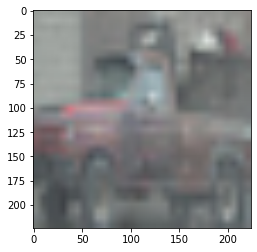

In [15]:
plt.imshow(img.permute([1,2,0])*0.5+0.5)

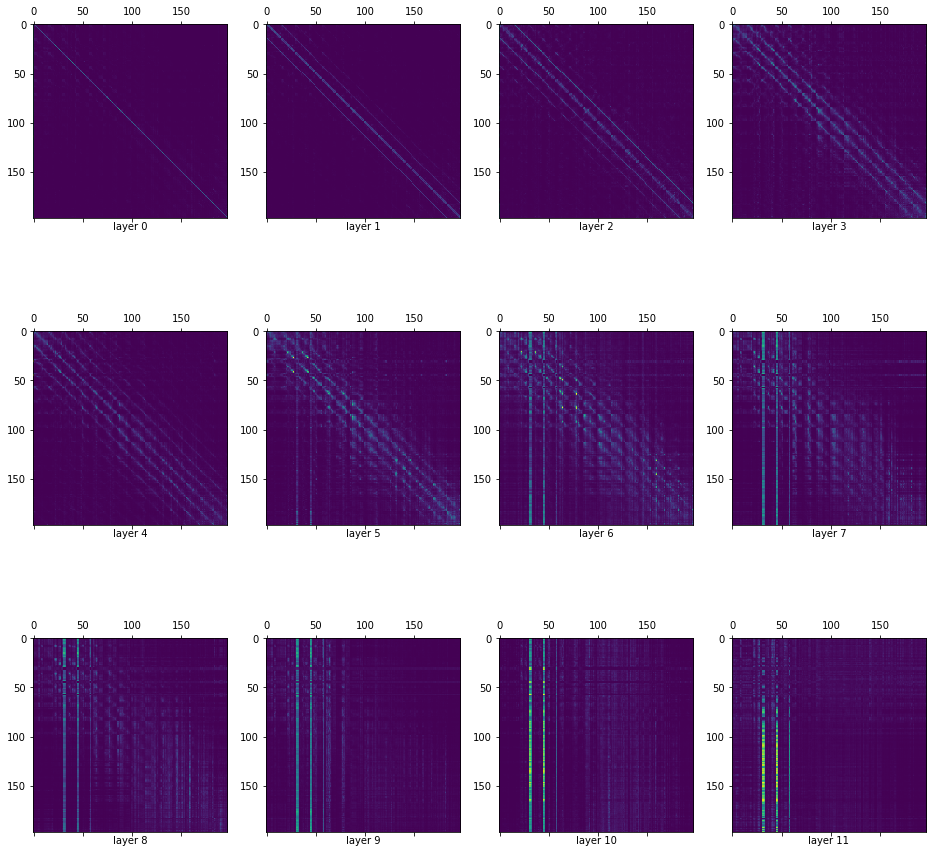

In [20]:
# vis attention at different layers
fig = plt.figure(figsize= (16,16))
for i, weight in enumerate(weights):
    weight = weight.mean(axis=0)
    ax = fig.add_subplot(3, 4, i + 1)
    ax = plt.gca()
    ax.matshow(weight)
    ax.set_xlabel(f'layer {i}')

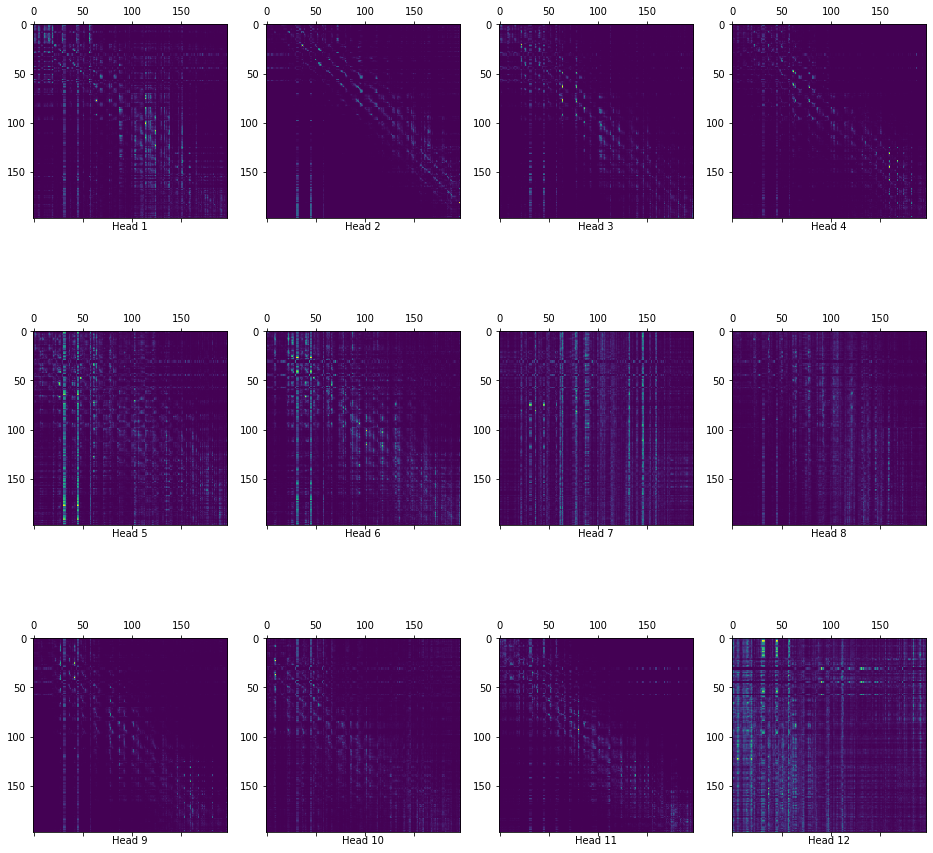

In [16]:
fig = plt.figure(figsize= (16,16))
for h, head in enumerate(A):
    ax = fig.add_subplot(3, 4, h + 1)
    ax = plt.gca()
    ax.matshow(head)
    ax.set_xlabel(f'Head {h+1}')

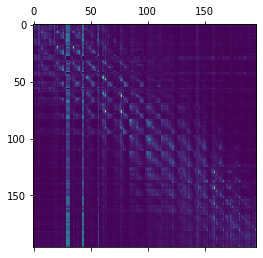

<Figure size 432x288 with 0 Axes>

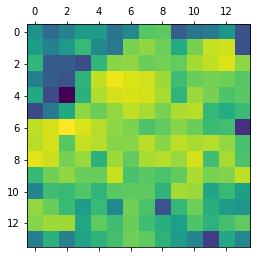

In [17]:
mean_A = A.mean(axis=0) # merge heads.
mean_A = mean_A[1:,1:] # remove the cls token.
## calculate the importance map.
importance_map = mean_A.mean(axis=1)
importance_map = (importance_map - importance_map.min()) / (importance_map.max()- importance_map.min())
importance_map = importance_map.reshape(14,14)

plt.matshow(mean_A)
figure = plt.figure()
plt.matshow(importance_map)

In [18]:
def overlap_heatmap(img, weight):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    attn_map = np.array(weight*255, dtype=np.uint8)
    attn_map = cv2.resize(attn_map, (224,224))
    heatmap = cv2.applyColorMap(attn_map, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay

(224, 224, 3)


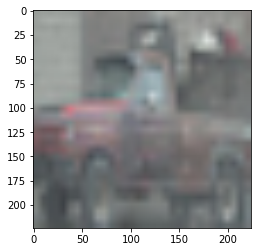

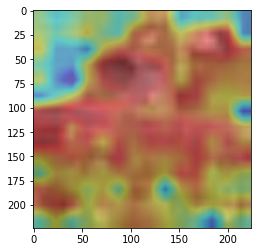

In [19]:
img_np = (img.permute([1,2,0]).numpy()*0.5+0.5)*255
img_np = img_np.astype(np.uint8)
print(img_np.shape)
img_pil = Image.fromarray(img_np,'RGB')
plt.imshow(img_pil)
plt.figure()
overlay = overlap_heatmap(img_np, importance_map)
plt.imshow(overlay)

In [10]:
def calculate_inverse(A,alpha=0.1):
    attention_probs = A
    num_patches = attention_probs.shape[-1]
    I = torch.eye(num_patches, device=attention_probs.device).unsqueeze(0)
    S = torch.linalg.inv(I - alpha * attention_probs)
    return S

tensor([2.1543e-03, 3.5055e-03, 3.3009e-03, 6.2298e-03, 2.1695e-02, 2.8211e-03,
        4.0877e-03, 3.5781e-03, 2.3218e-03, 1.4347e-02, 1.5173e-02, 1.2170e-02,
        2.0108e-02, 9.4343e-03, 1.1349e-02, 2.6009e-03, 5.8411e-03, 2.4811e-03,
        1.3390e-02, 3.0182e-03, 9.5457e-04, 1.4747e-03, 6.9333e-04, 1.3688e-03,
        9.9466e-04, 4.3084e-02, 9.7800e-02, 5.9946e-02, 3.9601e-03, 4.0295e-03,
        7.6232e-02, 7.7748e-02, 7.1250e-02, 2.6696e-03, 3.1293e-03, 1.2796e-03,
        1.7472e-03, 5.7917e-04, 1.1402e-03, 1.2232e-02, 8.0403e-02, 1.9865e-02,
        1.2953e-02, 5.0616e-03, 7.8476e-02, 7.3554e-02, 2.8473e-03, 9.4696e-04,
        3.6100e-04, 1.2548e-04, 3.3822e-03, 1.0598e-03, 2.9724e-03, 1.0670e-03,
        9.8704e-04, 1.1144e-03, 2.7665e-04, 6.2636e-03, 4.8772e-02, 1.2887e-03,
        1.4488e-03, 7.3081e-04, 2.1799e-03, 5.8584e-04, 2.2947e-04, 2.4888e-04,
        5.7226e-04, 4.1809e-04, 2.2662e-04, 6.8977e-05, 4.6249e-04, 2.3816e-04,
        2.0439e-04, 6.6225e-05, 7.0353e-

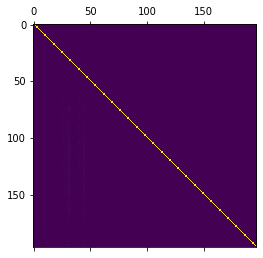

In [11]:
# S.shape = A.shape = (num_heads, num_patches, num_patches)
S = calculate_inverse(A,0.1)  #(12, 196, 196)
print(A[0][98]) 
print(S[0][98])
plt.matshow(S[0])

tensor([2.1543e-03, 3.5055e-03, 3.3009e-03, 6.2298e-03, 2.1695e-02, 2.8211e-03,
        4.0877e-03, 3.5781e-03, 2.3218e-03, 1.4347e-02, 1.5173e-02, 1.2170e-02,
        2.0108e-02, 9.4343e-03, 1.1349e-02, 2.6009e-03, 5.8411e-03, 2.4811e-03,
        1.3390e-02, 3.0182e-03, 9.5457e-04, 1.4747e-03, 6.9333e-04, 1.3688e-03,
        9.9466e-04, 4.3084e-02, 9.7800e-02, 5.9946e-02, 3.9601e-03, 4.0295e-03,
        7.6232e-02, 7.7748e-02, 7.1250e-02, 2.6696e-03, 3.1293e-03, 1.2796e-03,
        1.7472e-03, 5.7917e-04, 1.1402e-03, 1.2232e-02, 8.0403e-02, 1.9865e-02,
        1.2953e-02, 5.0616e-03, 7.8476e-02, 7.3554e-02, 2.8473e-03, 9.4696e-04,
        3.6100e-04, 1.2548e-04, 3.3822e-03, 1.0598e-03, 2.9724e-03, 1.0670e-03,
        9.8704e-04, 1.1144e-03, 2.7665e-04, 6.2636e-03, 4.8772e-02, 1.2887e-03,
        1.4488e-03, 7.3081e-04, 2.1799e-03, 5.8584e-04, 2.2947e-04, 2.4888e-04,
        5.7226e-04, 4.1809e-04, 2.2662e-04, 6.8977e-05, 4.6249e-04, 2.3816e-04,
        2.0439e-04, 6.6225e-05, 7.0353e-

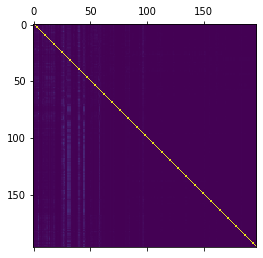

In [12]:
S = calculate_inverse(A,0.6)
print(A[0][98])
print(S[0][98])
print(S[0][98][98])
plt.matshow(S[0])

tensor([5.3716e-05, 1.0627e-05, 9.4655e-06, 9.8362e-05, 5.5631e-04, 3.4172e-05,
        6.9713e-05, 2.0007e-04, 8.8745e-05, 9.5156e-05, 1.2395e-04, 1.2794e-04,
        2.0486e-04, 1.7166e-05, 1.1848e-04, 2.2717e-05, 2.3269e-05, 7.5643e-05,
        1.9453e-04, 4.0942e-05, 1.6052e-04, 1.1337e-04, 6.4084e-05, 1.5587e-04,
        7.3679e-04, 5.1475e-04, 3.7552e-04, 8.0253e-04, 1.2381e-04, 6.6892e-05,
        5.3482e-02, 5.5150e-02, 3.7246e-02, 9.8617e-04, 1.3172e-03, 8.6671e-04,
        2.3531e-04, 1.7640e-04, 1.6286e-04, 1.7762e-04, 3.3291e-04, 3.0217e-04,
        3.8528e-04, 8.8552e-05, 5.7178e-02, 4.6920e-02, 7.0045e-05, 4.2787e-05,
        1.3922e-04, 6.5593e-04, 8.8957e-03, 4.9462e-03, 2.1829e-04, 4.8665e-05,
        5.1090e-05, 1.0731e-04, 3.8189e-04, 1.0440e-04, 1.4903e-02, 2.0541e-04,
        8.4966e-04, 1.0669e-04, 5.3057e-04, 1.5376e-03, 5.4986e-04, 8.5708e-04,
        3.9292e-04, 1.6969e-05, 4.3336e-05, 2.3873e-05, 1.7503e-04, 2.4996e-03,
        4.5895e-04, 3.0570e-03, 1.2938e-

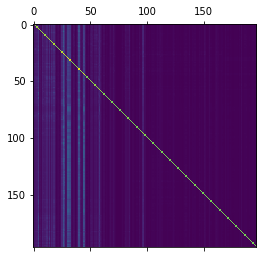

In [13]:
S = calculate_inverse(A,0.9)
print(A[0][0])
print(S[0][0])
plt.matshow(S[0])